# **Caspian Sea Dataset Assessment**


---




# Import Data and Libraries

In [ ]:
#------------------------------Mount Drive------------------------------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#------------------------------Import Libraries------------------------------
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import model_from_json
import glob
import os
from tensorflow.keras.models import load_model

In [ ]:
#------------------------------Install Patchify------------------------------
!pip install patchify
from patchify import patchify, unpatchify

In [ ]:
#------------------------------Install Rasterio------------------------------
!pip install rasterio
import rasterio

     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:
#------------------------------Define Paths------------------------------
data_path = '/content/drive/MyDrive/deep learning/final results/test 2/data/' 
model_path = '/content/drive/MyDrive/deep learning/final results/models/'
save_path = '/content/drive/MyDrive/deep learning/final results/test 2/output/' 

In [ ]:
#------------------------------Read Masks------------------------------
mask_165034 = plt.imread(data_path + '165034-mask.tif').astype(bool)
mask_166034 = plt.imread(data_path + '166034-mask.tif').astype(bool)
mask_166032 = plt.imread(data_path + '166032-mask.tif').astype(bool)

nrows_165034, ncols_165034 = mask_165034.shape[0] // 512, mask_165034.shape[1] // 512
nrows_166034, ncols_166034 = mask_166034.shape[0] // 512, mask_166034.shape[1] // 512
nrows_166032, ncols_166032 = mask_166032.shape[0] // 512, mask_166032.shape[1] // 512

mask_165034[nrows_165034*512:, :] = False
mask_165034[:, ncols_165034*512:] = False
mask_166034[nrows_166034*512:, :] = False
mask_166034[:, ncols_166034*512:] = False
mask_166032[nrows_166032*512:, :] = False
mask_166032[:, ncols_166032*512:] = False

In [ ]:
#------------------------------Read Images------------------------------
file_names = [os.path.basename(x) for x in glob.glob(data_path + 'rgb/*.tif')]
file_names = [os.path.splitext(x)[0][:-4] for x in file_names]

rgb = [plt.imread(data_path + 'rgb/' + name + '-rgb.tif') for name in file_names]
nir = [plt.imread(data_path + 'nir/' + name + '-nir.tif') for name in file_names]
ndwi = [plt.imread(data_path + 'ndwi/' + name + '-ndwi.tif') for name in file_names]
gt = [plt.imread(data_path + 'gt/' + name + '-gt.tif') for name in file_names]

profiles = []
for name in file_names:
  with rasterio.open(data_path + 'gt/' + name + '-gt.tif', driver='GTiff') as src:
        profiles.append(src.profile)

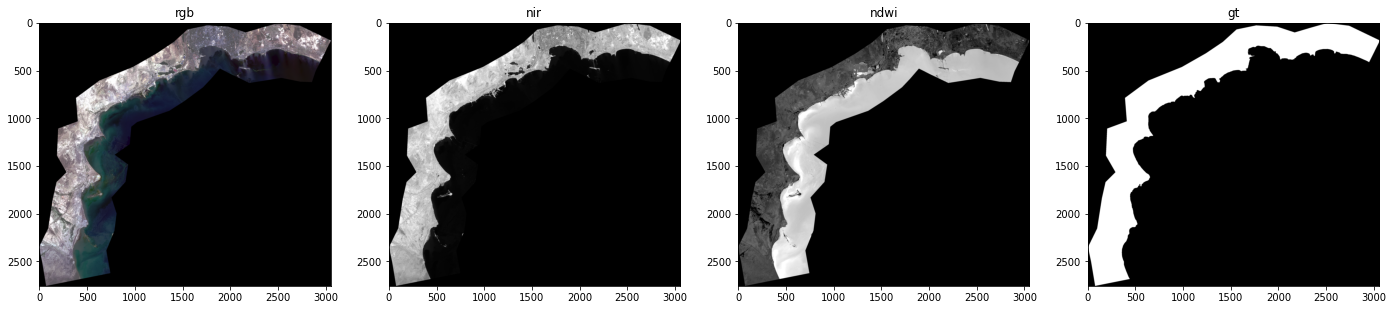

In [ ]:
#------------------------------Sanity Check------------------------------
num = np.random.randint(len(rgb))
num = -1
plt.figure(figsize=(24, 14))
plt.subplot(141)
plt.title('rgb')
plt.imshow(rgb[num])
plt.subplot(142)
plt.title('nir')
plt.imshow(nir[num], cmap='gray')
plt.subplot(143)
plt.title('ndwi')
plt.imshow(ndwi[num], cmap='gray')
plt.subplot(144)
plt.title('gt')
plt.imshow(gt[num], cmap='gray')
plt.show()

In [ ]:
#@title Metrics Calculation Functions{display-mode: "form"}

#---------------------------Confusion Matrix Function---------------------------
def confusion_mat(GT, Predict):
    assert len(np.unique(GT))<=2 and len(np.unique(Predict))<=2, \
    'inputs must have either two classes or one'
    
    GT, Predict = np.clip(GT, 0, 1), np.clip(Predict, 0, 1)
    # True Positive, False Positive
    TP = np.logical_and(GT==1, Predict==1)
    FP = np.logical_and(GT==0, Predict==1)
    # False Negative, True Negative
    FN = np.logical_and(GT==1, Predict==0)
    TN = np.logical_and(GT==0, Predict==0)
    
    # Validate Calculations
    assert np.sum(TP+TN+FP+FN) == GT.size,\
    '------Calculations Invalid------'

    return [TP.sum(), FP.sum(), FN.sum(), TN.sum()]


#---------------------------Metrics Function---------------------------
def _metrics(confusion_matrix):
  TP, FP = confusion_matrix[0], confusion_matrix[1]
  FN, TN = confusion_matrix[2], confusion_matrix[3]

  # accuracy (ACC)
  ACC = (TP+TN) / (TP+TN+FP+FN)
  # sensitivity, recall, hit rate, or true positive rate (TPR)
  TPR = TP / (TP+FN)
  # precision or positive predictive value (PPV)
  PPV = TP / (TP+FP)
  # F1-score
  F1 = (2*PPV*TPR) / (PPV+TPR)
  # Intersection over Union (IoU)
  IoU = TP / (TP+FP+FN)

  output = np.array([ACC, TPR, PPV, F1, IoU])
  return np.nan_to_num(output)


#---------------------------All Metrics---------------------------
def all_metrics(GT, PRD, fnames):
  images = []
  metrics = []
  for gt, prd, fname in zip(GT, PRD, fnames):
    if fname[:6] == '165034':
      mask = mask_165034.copy()
    elif fname[:6] == '166032':
      mask = mask_166032.copy()
    elif fname[:6] == '166034':
      mask = mask_166034.copy()

    prd[~mask] = 0
    images.append(prd)

    conf_mat = confusion_mat(gt[mask] ,prd[mask])
    metric = _metrics(conf_mat)
    metrics.append(metric)

  metrics = np.array(metrics)
  
  print('Total Number of Images: ', len(metrics))
  print('-------------------------------')
  f_result = np.mean(metrics, axis=0)
  print('Mean Metrics:')
  print('\tMean Accuracy:    {:.4f}'.format(f_result[0]))
  print('\tMean Sensitivity: {:.4f}'.format(f_result[1]))
  print('\tMean Precision:   {:.4f}'.format(f_result[2]))
  print('\tMean F1-Score:    {:.4f}'.format(f_result[3]))
  print('\tMean IoU:         {:.4f}'.format(f_result[4]))
  print('---------------------------------------------')

  return metrics, images

# fcdensenet

In [ ]:
model_fc = load_model(model_path + 'fcdensenet_model_23.h5', compile=False) #12

pred_fc = []
for rgbi in rgb:
  patches = patchify(rgbi, (512, 512, 3), step=512)
  nrows, ncols = patches.shape[0], patches.shape[1]
  patches = patches.reshape(nrows*ncols, 512, 512, 3)

  output = model_fc.predict(patches, batch_size=3, verbose=1)
  unpatched = unpatchify(output.reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(rgbi.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred_fc.append(output_full)
output_thr_fc = [(x>0.5).astype('uint8') for x in pred_fc]

In [ ]:
# read predictions
output_thr_fc = [np.clip(plt.imread(f'{save_path}fcdensenet/{name}-fcdensenet.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_fc, images_fc = all_metrics(gt, output_thr_fc, file_names)
print(metrics_fc)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9242
	Mean Sensitivity: 0.8567
	Mean Precision:   0.9899
	Mean F1-Score:    0.9144
	Mean IoU:         0.8492
---------------------------------------------
[[0.8844037  0.81314018 0.92546195 0.86567281 0.76315971]
 [0.98868678 0.98442795 0.99084324 0.98762518 0.97555288]
 [0.9875861  0.98450924 0.98839832 0.98644994 0.97326219]
 [0.99425581 0.99014355 0.99735593 0.99373665 0.98755127]
 [0.91290309 0.81634611 0.99302181 0.89605821 0.81168973]
 [0.95878724 0.92250673 0.98691293 0.95362359 0.91135808]
 [0.96253159 0.92433405 0.99795422 0.95973437 0.92258587]
 [0.96972539 0.94279526 0.99411187 0.96777377 0.93755975]
 [0.88851565 0.77344071 0.9937078  0.86984661 0.76967128]
 [0.95444413 0.911354   0.99346215 0.95063842 0.90592073]
 [0.9381931  0.87952718 0.99095181 0.9319207  0.87252015]
 [0.76353614 0.51126308 0.99502848 0.67546196 0.50996041]
 [0.90317346 0.82102996 0.99818918 0.90098351 0.819808

In [ ]:
del pred_fc, output_thr_fc

In [ ]:
for name, img, profile in zip(file_names, images_fc, profiles):
  with rasterio.open(save_path + 'fcdensenet/' + name + '-fcdensenet.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)

# deeplab

In [ ]:
model_dl = load_model(model_path + 'deeplab_model_43.h5', compile=False) #14, 15, 37, 44, 46

pred_dl = []
for rgbi in rgb:
  patches = patchify(rgbi, (512, 512, 3), step=512)
  nrows, ncols = patches.shape[0], patches.shape[1]
  patches = patches.reshape(nrows*ncols, 512, 512, 3)

  output = model_dl.predict(patches, batch_size=3, verbose=1)
  output = np.argmax(output, axis=-1)
  unpatched = unpatchify(output.reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(rgbi.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred_dl.append(output_full)

In [ ]:
# read predictions
pred_dl = [np.clip(plt.imread(f'{save_path}deeplab/{name}-deeplab.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_dl, images_dl = all_metrics(gt, pred_dl, file_names)
print(metrics_dl)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.8044
	Mean Sensitivity: 0.7075
	Mean Precision:   0.8761
	Mean F1-Score:    0.7761
	Mean IoU:         0.6472
---------------------------------------------
[[0.8686612  0.76731269 0.93421691 0.84257892 0.72797959]
 [0.90171653 0.8438152  0.93554904 0.88731748 0.79745792]
 [0.90665326 0.85474095 0.93633171 0.89367794 0.80779184]
 [0.89358022 0.86036675 0.90377462 0.88153664 0.78816765]
 [0.84157108 0.74046442 0.89706569 0.81127696 0.68247769]
 [0.87821591 0.81754736 0.90814708 0.86046896 0.75510796]
 [0.84221256 0.83159883 0.8401492  0.83585215 0.71799484]
 [0.87250363 0.85658816 0.87621433 0.8662901  0.76411973]
 [0.88822699 0.83793123 0.92291459 0.87837214 0.78312261]
 [0.88939935 0.85140178 0.91295378 0.88110411 0.78747641]
 [0.83378653 0.79064066 0.85303309 0.8206527  0.69585329]
 [0.74561403 0.57725022 0.84513422 0.68596633 0.52203101]
 [0.66382693 0.4724986  0.82671667 0.60132063 0.429920

In [ ]:
del pred_dl

In [ ]:
for name, img, profile in zip(file_names, images_dl, profiles):
  with rasterio.open(save_path + 'deeplab/' + name + '-deeplab.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)

# model 1 scenario 1

In [ ]:
model1_s1 = load_model(model_path + 'model1_scenario1.h5', compile=False)

pred1_s1 = []
for rgbi in rgb:
  patches = patchify(rgbi, (512, 512, 3), step=512)
  nrows, ncols = patches.shape[0], patches.shape[1]
  patches = patches.reshape(nrows*ncols, 512, 512, 3)

  output = model1_s1.predict(patches, verbose=1)
  unpatched = unpatchify(output.reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(rgbi.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred1_s1.append(output_full)

output_thr_m1s1 = [(x>0.5).astype('uint8') for x in pred1_s1]

In [ ]:
# read predictions
output_thr_m1s1 = [np.clip(plt.imread(f'{save_path}m1s1/{name}-m1s1.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_m1s1, images_m1s1 = all_metrics(gt, output_thr_m1s1, file_names)
print(metrics_m1s1)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9462
	Mean Sensitivity: 0.9094
	Mean Precision:   0.9862
	Mean F1-Score:    0.9437
	Mean IoU:         0.8992
---------------------------------------------
[[0.97813201 0.96818482 0.98381934 0.97593947 0.95300956]
 [0.99376946 0.98948962 0.99690109 0.99318153 0.98645541]
 [0.99585039 0.99217597 0.99877497 0.99546454 0.99097003]
 [0.9971137  0.99505931 0.9986643  0.99685855 0.99373677]
 [0.98599882 0.97350043 0.99596324 0.98460374 0.96967437]
 [0.98807245 0.98113809 0.99280934 0.98693921 0.9742152 ]
 [0.98310753 0.97944571 0.98549728 0.98246218 0.9655289 ]
 [0.99381564 0.99039326 0.99675981 0.99356634 0.98721493]
 [0.98995304 0.98565364 0.99343608 0.98952956 0.9792761 ]
 [0.98357657 0.9668585  0.99898889 0.98266112 0.96591326]
 [0.96506442 0.96823577 0.95949799 0.96384708 0.93021702]
 [0.95706377 0.91299511 0.99759399 0.95342158 0.91098914]
 [0.85681887 0.73474327 0.99783301 0.8463132  0.733572

In [ ]:
del pred1_s1, output_thr_m1s1

In [ ]:
for name, img, profile in zip(file_names, images_m1s1, profiles):
  with rasterio.open(save_path + 'm1s1/' + name + '-m1s1.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)

# model 1 scenario 2

In [ ]:
model1_s2 = load_model(model_path + 'model1_scenario2.h5', compile=False)

pred1_s2 = []
for ndwii in ndwi:
  patches = patchify(ndwii, (512, 512), step=512)
  nrows, ncols = patches.shape[0], patches.shape[1]
  patches = patches.reshape(nrows*ncols, 512, 512)

  patches = patches.astype('float') / 255
  patches = np.expand_dims(patches, axis=-1)
  output = model1_s2.predict(patches, verbose=1)
  unpatched = unpatchify(output.reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(ndwii.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred1_s2.append(output_full)

output_thr_m1s2 = [(x>0.5).astype('uint8') for x in pred1_s2]

In [ ]:
# read predictions
output_thr_m1s2 = [np.clip(plt.imread(f'{save_path}m1s2/{name}-m1s2.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_m1s2, images_m1s2 = all_metrics(gt, output_thr_m1s2, file_names)
print(metrics_m1s2)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9879
	Mean Sensitivity: 0.9780
	Mean Precision:   0.9973
	Mean F1-Score:    0.9875
	Mean IoU:         0.9754
---------------------------------------------
[[0.99529602 0.99152331 0.99819565 0.99484829 0.98974939]
 [0.9900546  0.97995566 0.9983267  0.98905588 0.97834871]
 [0.99465381 0.98985284 0.99848605 0.9941507  0.98836943]
 [0.98691262 0.9725912  0.99894367 0.98559132 0.97159196]
 [0.99607741 0.99249395 0.99896977 0.99572133 0.99147912]
 [0.98914863 0.97976885 0.99654798 0.98808719 0.97645486]
 [0.98098337 0.96310619 0.99744068 0.97997279 0.96073201]
 [0.98342339 0.96745941 0.99810278 0.98254223 0.96568355]
 [0.98500016 0.97087891 0.99792309 0.98421526 0.96892109]
 [0.98159188 0.9637439  0.99794224 0.98054498 0.9618325 ]
 [0.981657   0.96385623 0.99793608 0.98060014 0.96193867]
 [0.98354988 0.96794284 0.99781397 0.98265145 0.96589457]
 [0.99275054 0.98971503 0.99675093 0.99322052 0.986532

In [ ]:
del pred1_s2, output_thr_m1s2

In [ ]:
for name, img, profile in zip(file_names, images_m1s2, profiles):
  with rasterio.open(save_path + 'm1s2/' + name + '-m1s2.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)

# model 2 scenario 1

In [ ]:
model2_s1 = load_model(model_path + 'model2_scenario1_038.h5', compile=False)

pred2_s1 = []
for rgbi, niri in zip(rgb, nir):
  stack = np.concatenate((rgbi, np.expand_dims(niri, axis=-1)), axis=-1)
  patches = patchify(stack, (512, 512, 4), step=512)
  nrows, ncols = patches.shape[0], patches.shape[1]
  patches = patches.reshape(nrows*ncols, 512, 512, 4)

  output = model2_s1.predict(patches, verbose=1)
  unpatched = unpatchify(output.reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(rgbi.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred2_s1.append(output_full)

output_thr_m2s1 = [(x>0.5).astype('uint8') for x in pred2_s1]

In [ ]:
# read predictions
output_thr_m2s1 = [np.clip(plt.imread(f'{save_path}m2s1/{name}-m2s1.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_m2s1, images_m2s1 = all_metrics(gt, output_thr_m2s1, file_names)
print(metrics_m2s1)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9913
	Mean Sensitivity: 0.9853
	Mean Precision:   0.9976
	Mean F1-Score:    0.9914
	Mean IoU:         0.9829
---------------------------------------------
[[0.99763263 0.99542653 0.99940304 0.99741082 0.99483501]
 [0.99724949 0.99580221 0.99819573 0.99699754 0.99401305]
 [0.99771134 0.99591763 0.99909308 0.99750282 0.99501809]
 [0.99709989 0.99436839 0.99932669 0.99684137 0.99370264]
 [0.99749736 0.9959619  0.99859245 0.99727544 0.99456569]
 [0.99616889 0.99478914 0.99686344 0.99582521 0.99168514]
 [0.98905013 0.9785476  0.99876074 0.98855086 0.97736091]
 [0.99601041 0.99365933 0.99805778 0.9958537  0.99174163]
 [0.99801581 0.99670464 0.99917386 0.99793772 0.99588393]
 [0.98702951 0.97368583 0.99935098 0.98635148 0.97307051]
 [0.98954138 0.9802939  0.99792477 0.98903077 0.97829957]
 [0.98952566 0.97897448 0.99924816 0.98900743 0.97825391]
 [0.99061662 0.98491732 0.99756362 0.99120013 0.982553

In [ ]:
del pred2_s1, output_thr_m2s1

In [ ]:
for name, img, profile in zip(file_names, images_m2s1, profiles):
  with rasterio.open(save_path + 'm2s1/' + name + '-m2s1.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)

# model 2 scenario 2

In [ ]:
model2_s2 = load_model(model_path + 'model2_scenario2.h5', compile=False)

pred2_s2 = []
for rgbi, niri in zip(rgb, nir):
  stack = np.concatenate((rgbi, np.expand_dims(niri, axis=-1)), axis=-1)
  patches = patchify(stack, (512, 512, 4), step=512)
  nrows, ncols = patches.shape[0], patches.shape[1]
  patches = patches.reshape(nrows*ncols, 512, 512, 4)

  output = model2_s2.predict(patches, verbose=1)
  unpatched = unpatchify(output.reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(rgbi.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred2_s2.append(output_full)

output_thr_m2s2 = [(x>0.5).astype('uint8') for x in pred2_s2]

In [ ]:
# read predictions
output_thr_m2s2 = [np.clip(plt.imread(f'{save_path}m2s2/{name}-m2s2.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_m2s2, images_m2s2 = all_metrics(gt, output_thr_m2s2, file_names)
print(metrics_m2s2)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9943
	Mean Sensitivity: 0.9905
	Mean Precision:   0.9982
	Mean F1-Score:    0.9943
	Mean IoU:         0.9887
---------------------------------------------
[[0.99709937 0.99422996 0.9994349  0.99682564 0.99367136]
 [0.99785078 0.99591816 0.99939317 0.99765264 0.99531627]
 [0.99807884 0.99638271 0.99942983 0.99790394 0.99581665]
 [0.99822324 0.99733144 0.99880611 0.99806823 0.99614391]
 [0.99857588 0.99903029 0.99787544 0.99845253 0.99690985]
 [0.99692656 0.99602447 0.99728078 0.99665223 0.9933268 ]
 [0.98949023 0.97884456 0.99938729 0.98900926 0.97825749]
 [0.99663912 0.9936319  0.99939421 0.99650473 0.9930338 ]
 [0.99878473 0.99817155 0.99930461 0.99873776 0.99747869]
 [0.9878179  0.97572232 0.99894452 0.98719687 0.97471744]
 [0.99196617 0.98428491 0.99899707 0.99158642 0.98331324]
 [0.98963918 0.97932177 0.99913481 0.98912909 0.97849198]
 [0.99292863 0.98887946 0.99792252 0.99338041 0.986847

In [ ]:
del pred2_s2, output_thr_m2s2

In [ ]:
for name, img, profile in zip(file_names, images_m2s2, profiles):
  with rasterio.open(save_path + 'm2s2/' + name + '-m2s2.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)

# model 3 scenario 1

In [ ]:
model3_s1 = load_model(model_path + 'model3_scenario1.h5', compile=False)

pred3_s1 = []
for rgbi in rgb:
  patches = patchify(rgbi, (512, 512, 3), step=512)
  nrows, ncols = patches.shape[0], patches.shape[1]
  patches = patches.reshape(nrows*ncols, 512, 512, 3)

  output = model3_s1.predict(patches, verbose=1)
  unpatched = unpatchify(output[:, :, :, 1].reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(rgbi.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred3_s1.append(output_full)

output_thr_m3s1 = [(x>0.5).astype('uint8') for x in pred3_s1]

In [ ]:
# read predictions
output_thr_m3s1 = [np.clip(plt.imread(f'{save_path}m3s1/{name}-m3s1.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_m3s1, images_m3s1 = all_metrics(gt, output_thr_m3s1, file_names)
print(metrics_m3s1)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9594
	Mean Sensitivity: 0.9282
	Mean Precision:   0.9910
	Mean F1-Score:    0.9581
	Mean IoU:         0.9209
---------------------------------------------
[[0.96221332 0.92060999 0.99664417 0.95711941 0.91776509]
 [0.97953319 0.96174366 0.9934167  0.97732363 0.95565289]
 [0.98849521 0.97780163 0.99707576 0.98734464 0.97500559]
 [0.98545409 0.97112837 0.99719178 0.98398752 0.96847975]
 [0.95703133 0.91129217 0.99483995 0.95123507 0.90700503]
 [0.97786329 0.96261268 0.98889732 0.97557799 0.9523204 ]
 [0.98691325 0.97560021 0.9972501  0.98630636 0.97298269]
 [0.99094177 0.98400498 0.99717108 0.99054428 0.98126571]
 [0.98778223 0.97677969 0.99780836 0.98718205 0.97468854]
 [0.98332209 0.96699896 0.99829892 0.9823997  0.96540822]
 [0.97256409 0.94866713 0.99401753 0.97081299 0.94328143]
 [0.92207131 0.84091523 0.99665238 0.9121843  0.83854674]
 [0.92863761 0.86900628 0.99769555 0.92891503 0.867265

In [ ]:
del pred3_s1, output_thr_m3s1

In [ ]:
for name, img, profile in zip(file_names, images_m3s1, profiles):
  with rasterio.open(save_path + 'm3s1/' + name + '-m3s1.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)

# model 3 scenario 2

In [ ]:
model3_s2 = load_model(model_path + 'model3_scenario2.h5', compile=False)

pred3_s2 = []
for ndwii in ndwi:
  patches = patchify(ndwii, (512, 512), step=512)
  nrows, ncols = patches.shape[0], patches.shape[1]
  patches = patches.reshape(nrows*ncols, 512, 512)

  patches = np.expand_dims(patches, axis=-1)
  output = model3_s2.predict(patches, verbose=1)
  unpatched = unpatchify(output[:, :, :, 1].reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(ndwii.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred3_s2.append(output_full)

output_thr_m3s2 = [(x>0.5).astype('uint8') for x in pred3_s2]

In [ ]:
# read predictions
output_thr_m3s2 = [np.clip(plt.imread(f'{save_path}m3s2/{name}-m3s2.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_m3s2, images_m3s2 = all_metrics(gt, output_thr_m3s2, file_names)
print(metrics_m3s2)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9882
	Mean Sensitivity: 0.9801
	Mean Precision:   0.9959
	Mean F1-Score:    0.9879
	Mean IoU:         0.9761
---------------------------------------------
[[0.99469238 0.99096286 0.99743374 0.99418778 0.98844272]
 [0.99163667 0.98380448 0.9979292  0.9908165  0.98180015]
 [0.99641676 0.99430148 0.99788392 0.99608948 0.99220943]
 [0.98918147 0.97786999 0.99859349 0.9881231  0.976525  ]
 [0.99536978 0.99150497 0.99841573 0.99494835 0.98994749]
 [0.99018805 0.98269403 0.99588943 0.98924773 0.97872422]
 [0.98287476 0.96795052 0.99649939 0.9820175  0.96467033]
 [0.98326072 0.96803377 0.99716652 0.98238421 0.96537831]
 [0.98560094 0.97274362 0.99729537 0.98486651 0.97018423]
 [0.98208687 0.96600016 0.99668273 0.98110161 0.96290427]
 [0.98190774 0.96558045 0.99670064 0.98089378 0.96250396]
 [0.98436671 0.97055639 0.99688058 0.98354238 0.96761769]
 [0.99241797 0.99061948 0.99522748 0.99291814 0.985935

In [ ]:
del pred3_s2, output_thr_m3s2

In [ ]:
for name, img, profile in zip(file_names, images_m3s2, profiles):
  with rasterio.open(save_path + 'm3s2/' + name + '-m3s2.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)

# model 4 scenario 1

In [ ]:
model4_s1 = load_model(model_path + 'model4_scenario1_018.h5', compile=False)

pred4_s1 = []
for rgbi, niri in zip(rgb, nir):
  patches1 = patchify(rgbi, (512, 512, 3), step=512)
  patches2 = patchify(niri, (512, 512), step=512)
  nrows, ncols = patches1.shape[0], patches1.shape[1]
  patches1 = patches1.reshape(nrows*ncols, 512, 512, 3)
  patches2 = patches2.reshape(nrows*ncols, 512, 512)

  patches2 = np.expand_dims(patches2, axis=-1)
  output = model4_s1.predict([patches1, patches2], verbose=1)
  unpatched = unpatchify(output.reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(rgbi.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred4_s1.append(output_full)

output_thr_m4s1 = [(x>0.5).astype('uint8') for x in pred4_s1]

In [ ]:
# read predictions
output_thr_m4s1 = [np.clip(plt.imread(f'{save_path}m4s1/{name}-m4s1.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_m4s1, images_m4s1 = all_metrics(gt, output_thr_m4s1, file_names)
print(metrics_m4s1)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9775
	Mean Sensitivity: 0.9608
	Mean Precision:   0.9956
	Mean F1-Score:    0.9776
	Mean IoU:         0.9569
---------------------------------------------
[[0.995467   0.99155404 0.99854002 0.99503477 0.9901186 ]
 [0.99568463 0.99552827 0.99506397 0.99529606 0.99063618]
 [0.99615586 0.99480859 0.99680958 0.99580808 0.99165116]
 [0.99782159 0.99626051 0.99900335 0.99763004 0.99527129]
 [0.9979063  0.99723766 0.99820789 0.99772254 0.99545543]
 [0.99331491 0.9947795  0.99070432 0.99273772 0.98558017]
 [0.98493505 0.97011807 0.99865866 0.98418149 0.96885564]
 [0.99171843 0.98496431 0.99783192 0.99135636 0.98286087]
 [0.98986173 0.97958141 0.99935743 0.98937061 0.97896481]
 [0.98370381 0.96673825 0.99938594 0.98279104 0.96616435]
 [0.98470477 0.97086619 0.99726077 0.98388649 0.96828404]
 [0.98556326 0.97088191 0.99909799 0.98478788 0.97003164]
 [0.94762965 0.90504474 0.99708112 0.94883629 0.902653

In [ ]:
del pred4_s1, output_thr_m4s1

In [ ]:
for name, img, profile in zip(file_names, images_m4s1, profiles):
  with rasterio.open(save_path + 'm4s1/' + name + '-m4s1.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)

# model 4 scenario 2

In [ ]:
model4_s2 = load_model(model_path + 'model4_scenario2.h5', compile=False)

pred4_s2 = []
for rgbi, niri in zip(rgb, nir):
  patches1 = patchify(rgbi, (512, 512, 3), step=512)
  patches2 = patchify(niri, (512, 512), step=512)
  nrows, ncols = patches1.shape[0], patches1.shape[1]
  patches1 = patches1.reshape(nrows*ncols, 512, 512, 3)
  patches2 = patches2.reshape(nrows*ncols, 512, 512)

  patches2 = np.expand_dims(patches2, axis=-1)
  output = model4_s2.predict([patches1, patches2], batch_size=10, verbose=1)
  unpatched = unpatchify(output.reshape(nrows, ncols, 512, 512), (nrows*512, ncols*512))
  output_full = np.zeros(rgbi.shape[:2]).astype(output.dtype)
  output_full[:nrows*512, :ncols*512] = unpatched
  pred4_s2.append(output_full)

output_thr_m4s2 = [(x>0.5).astype('uint8') for x in pred4_s2]

In [ ]:
# read predictions
output_thr_m4s2 = [np.clip(plt.imread(f'{save_path}m4s2/{name}-m4s2.tif'), 0, 1) for name in file_names]

In [ ]:
metrics_m4s2, images_m4s2 = all_metrics(gt, output_thr_m4s2, file_names)
print(metrics_m4s2)

Total Number of Images:  18
-------------------------------
Mean Metrics:
	Mean Accuracy:    0.9900
	Mean Sensitivity: 0.9824
	Mean Precision:   0.9976
	Mean F1-Score:    0.9899
	Mean IoU:         0.9801
---------------------------------------------
[[0.99762168 0.99612068 0.99868398 0.99740069 0.99481485]
 [0.99424539 0.98843989 0.99900109 0.99369243 0.98746393]
 [0.99729667 0.99534635 0.99875952 0.99705002 0.99411739]
 [0.99432019 0.98818857 0.99946386 0.99379424 0.98766502]
 [0.99859386 0.99891297 0.99803115 0.99847186 0.99694839]
 [0.99369466 0.98885139 0.99739867 0.99310664 0.98630766]
 [0.98281613 0.96572099 0.99866376 0.98191615 0.96447473]
 [0.99074866 0.98203044 0.99876173 0.99032542 0.98083625]
 [0.98886352 0.97794513 0.99891115 0.98831696 0.97690376]
 [0.98550014 0.97109267 0.99874885 0.98472662 0.96991277]
 [0.98675009 0.97339546 0.9990316  0.98604693 0.97247788]
 [0.98633419 0.97318237 0.99838392 0.98562208 0.97165175]
 [0.98742264 0.97929647 0.99721252 0.9881733  0.976623

In [ ]:
del pred4_s2, output_thr_m4s2

In [ ]:
for name, img, profile in zip(file_names, images_m4s2, profiles):
  with rasterio.open(save_path + 'm4s2/' + name + '-m4s2.tif', 'w', **profile) as dst:
    dst.write((img * 255).astype(rasterio.uint8), 1)